In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

We will first try with the usual broken power law:

In [3]:
def br_po_lw(xdata, E1, fl_0, lam1, sqrtdelta_lam12):
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return polw

Now let's add the $\chi^2$ to the function in order to minimize:

In [22]:
def br_po_lw_chsq(params): 
    #you need to define theE, SED and SED_u before(E and SED must be a numpy.array and SED an scalar or a numpy.array)
    E1, fl_0, lam1, sqrtdelta_lam12 = params
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return np.sum(np.square(ydata - polw) / np.square(ydata_u))

Let's show an example:

In [5]:
initial_guess = [2.9, 9, 0.9, 1.3]
xdata = [1, 2, 2.99, 3, 4, 8, 25]
E_test = [1, 2, 2.99, 3, 4, 8, 25]
ydata = br_po_lw(xdata=xdata, E1=3, fl_0=10, lam1=1, sqrtdelta_lam12=1)
ydata_u = 0.1 * ydata

result = optimize.minimize(br_po_lw_chsq, initial_guess, method = 'Nelder-Mead')
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[2.99998113 9.99999299 0.99999413 1.00000247]


After getting the parameters, just use the original br_po_lw function with those parameters to get the fit:

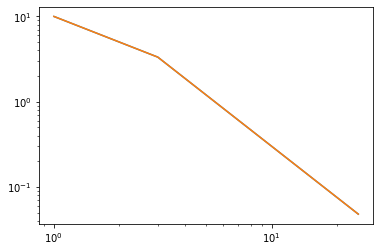

In [6]:
SED_fit = br_po_lw(E_test, result.x[0], result.x[1], result.x[2], result.x[3])

plt.plot(E_test, ydata, label='original')
plt.plot(E_test, SED_fit, label='fit')
plt.xscale('log')
plt.yscale('log')
plt.show()

Let's check the difference between the fit and the original one (in log scale)

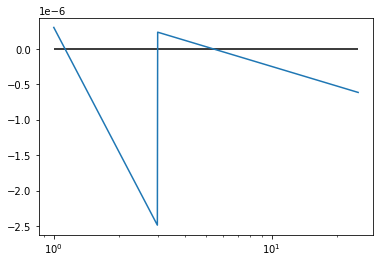

In [7]:
diff = np.log10(ydata) - np.log10(SED_fit)
plt.plot(E_test, diff)
plt.xscale('log')
plt.hlines(0, xmin=min(E_test), xmax=max(E_test), color = 'black')

Now let's try to minimize with iminuit

In [8]:
from iminuit import Minuit

In [9]:
br_po_lw_chsq.errordef = Minuit.LIKELIHOOD

m = Minuit(br_po_lw_chsq, initial_guess)

m.migrad()
print(m.values)

m.hesse()
print(m.errors)

<ValueView x0=2.999689879964007 x1=10.000410781931295 x2=0.999966702039753 x3=1.0000156360791759>
<ErrorView x0=0.23835213647930237 x1=0.6752404498950263 x2=0.09020794703164459 x3=0.05002506081972387>


In [10]:
print(m.values)
print(fitted_params)

<ValueView x0=2.999689879964007 x1=10.000410781931295 x2=0.999966702039753 x3=1.0000156360791759>
[2.99998113 9.99999299 0.99999413 1.00000247]


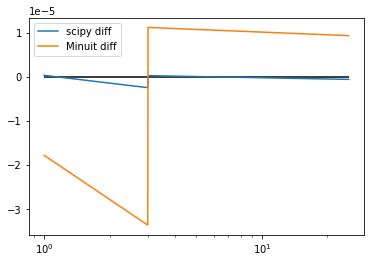

In [11]:
SED_fit_M = br_po_lw(E_test, m.values[0], m.values[1], m.values[2], m.values[3])

diff = np.log10(ydata) - np.log10(SED_fit)
diff_M = np.log10(ydata) - np.log10(SED_fit_M)

plt.plot(E_test, diff, label='scipy diff')
plt.plot(E_test, diff_M, label='Minuit diff')
plt.xscale('log')
plt.legend()
plt.hlines(0, xmin=min(E_test), xmax=max(E_test), color = 'black')
plt.show()

Now with real data

In [12]:
file = np.loadtxt('tau_dominguez11.out')

pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})

E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()
logE = np.log10(E)

K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)
SED = np.square(E) * dNdEa
SED_u = SED * 0.1

In [31]:
xdata = E[3:37]
ydata = SED[3:37]
ydata_u = SED_u[3:37]
initial_guess = np.array([0.3, 0, 0, 2]) #E1, fl_0, lam1, sqrtdelta_lam12

In [23]:
br_po_lw_chsq.errordef = Minuit.LIKELIHOOD

m = Minuit(br_po_lw_chsq, initial_guess)

m.migrad()
print(m.values)

m.hesse()
print(m.errors)

<ValueView x0=0.257092667285863 x1=6.045921027193106e-07 x2=0.2279235500017448 x3=1.1364742550949458>
<ErrorView x0=0.009606049168269447 x1=2.1489182947203434e-08 x2=0.035049917281418146 x3=0.017357282071367684>


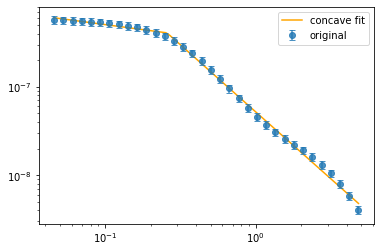

In [52]:
Egam = np.linspace(E[3],E[36], 300)

plt.plot(Egam, br_po_lw(Egam, m.values[0], m.values[1], m.values[2], m.values[3]), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [29]:
chisqtest = chisq(ydata, SED_fit, ydata_u)
print(chisqtest)

18.778817175584336


In [32]:
result = optimize.minimize(br_po_lw_chsq, initial_guess, method = 'Nelder-Mead')
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[2.08963555e-01 5.21083393e-07 5.91540420e-03 1.21549821e+00]


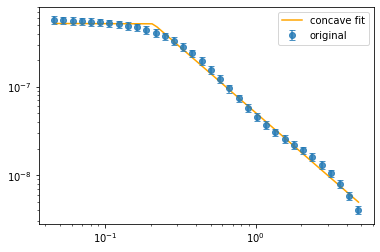

In [56]:
plt.plot(Egam, br_po_lw(Egam, result.x[0], result.x[1], result.x[2], result.x[3]), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [55]:
chisqtest = chisq(ydata, br_po_lw(xdata, result.x[0], result.x[1], result.x[2], result.x[3]), ydata_u)
print(chisqtest)

29.03386917404991


With the sample data scipy gives us a better result, but with the simulated data of the real source iminuit gives a much better fit.